# OLYMPEX Postfrontal Analysis

### Author: Alex Hewett


#### Undergraduate, Atmospheric Sciences Department, University of Washington

In [1]:
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
import os
import numpy.ma as ma
import scipy.stats as stats
import statsmodels.api as sm
# from metpy.plots import ctables
# cmap = ctables.registry.get_colortable('NWSReflectivity')

/home/disk/p/ahewett/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


To-do:<br>
Make hists for each<br>
make hists for all data<br>

# OLYMPEX NPOL/D3R radar

In [2]:
def get_olympex_data(date='20151204', start=0, end=2359):
    '''
    Takes a date in format yyyymmdd and start and end times in integers. Then checks the NPOL radar directory on
    the Bob machine to find all the NPOL scans on that date within the time range. Returns the files in
    west and east sectors.
    '''
    # Enter date='yyyymmdd'
    directory = f"/home/disk/bob/olympex/zebra/moments/npol_qc2/rhi_hires/{date}"
    west_files = []
    east_files = []
    for filename in os.listdir(directory):
        # Strip the name and the extension
        basename, ext = os.path.splitext(filename)
        # Make sure it's an .nc file
        if ext != '.nc':
            continue
        # get the time, it will strip leading zeroes, but that should be fine
        try:
            time = int(basename[-6:-2])
            sector = basename[9:13]
        except ValueError:
            continue
        # Check if the file is in the desired time range
        if start <= time <= end:
            # Append to either west or east files
            if sector == "west":
                west_files.append(os.path.join(directory, filename))
            elif sector == "east":
                east_files.append(os.path.join(directory, filename))
                
    return west_files, east_files

In [3]:
def get_ceiling_and_coverage(scan_files, coverage_out="coverage", ceiling_out='ceiling', directory='ceiling_data'):
    '''
    Takes an array of input files and then extracts the dBZ fields and finds the grid cells where there is a 
    return of > 15 dBZ. If the cell has such a return, it also finds the maximum level of where there is a 
    15 dBZ echo. The outputs are then stored into .npy files that can be loaded for analysis.
    
    Scan_files = NPOL radar files to be processed. Use get_olympex_data() to pass these in easily
    coverage_out = name of output file for coverage array
    ceiling_out = name of output file for ceiling array
    
    '''
    scan_len = len(scan_files)
    coverage = np.full([scan_len, 600, 600], np.nan) # Empty array to hold true/false 15 dBz in the column
    ceiling = np.full([scan_len, 600, 600], np.nan) # "" 15 dBZ max height in column (km)
    
    # Load the data
    for scan in range(scan_len):
        # Open the west and east scans for a given time interval
        dat = xr.open_dataset(scan_files[scan]) 
        # Get the DBZs and elevations
        dBZ = np.squeeze(dat['DBZ'].values) # DBZ radar return
        elevation = dat['z0'].values
        # print(f"STARTING scan {scan}, filename: {scan_files[scan]}") 
        # Iterate over the Y coordinates
        for i in range(600):
            # Iterate over the X coordinates
            for j in range(600):
                # Check if dBZ >15 at any level in the grid cell column
                if any(dBZ[:, i, j] > 15):
                    coverage[scan, i, j] = 1 # Set to true, means there's a > 15 dbz val in the column   
                    ceiling_15dBZ = np.where(dBZ[:, i, j] > 15) # Finds indices in column where dBZ > 15
                    ceiling_top = ceiling_15dBZ[0].max() # Takes the max level, which is the highest
                    ceiling[scan, i, j] = elevation[ceiling_top] # append to the ceiling array
                else:
                    continue
        # print(f"COMPLETED scan {scan}, filename: {scan_files[scan]}") 

    coverage_str = f"{directory}/{coverage_out}.npy" # Output file name for coverage
    ceiling_str = f"{directory}/{ceiling_out}.npy" # Output file name for ceiling 
    np.save(coverage_str, coverage)
    print(f"{coverage_str} saved.")
    np.save(ceiling_str, ceiling)
    print(f"{ceiling_str} saved.\n")

In [4]:
def get_west_east_ceiling(date="20151204", start=0, end=2359, directory='ceiling_data'):
    '''
    Takes a date in format yyyymmdd and start and end times. Calls the get_olympex_data func to glob files
    then processes both the west and east sector scans and saves them to the "ceiling_data/" directory.
    '''
    west_files, east_files = get_olympex_data(date, start, end)
    get_ceiling_and_coverage(west_files, coverage_out=f"{date}_west_coverage", ceiling_out=f'{date}_west_ceiling',
                             directory=directory)
    get_ceiling_and_coverage(east_files, coverage_out=f"{date}_east_coverage", ceiling_out=f'{date}_east_ceiling', 
                             directory=directory)

In [5]:
def load_west_east_ceiling(date="20151204", directory="ceiling_data"):
    '''
    Given a date, loads west and east sector ceiling arrays from the "ceiling_data/" directory. 
    Returns the west and east sector ceiling arrays.
    '''
    # Give date in yyyymmdd format, times in integer values
    west_data = np.load(f"{directory}/{date}_west_ceiling.npy")
    east_data = np.load(f"{directory}/{date}_east_ceiling.npy")
    return west_data, east_data

In [6]:
def load_west_east_coverage(date="20151204", directory='ceiling_data'):
    '''
    Given a date, loads west and east sector coverage arrays from the "ceiling_data/" directory. 
    if given another directory, it will look there.
    Returns the west and east sector ceiling arrays.
    '''
    # Give date in yyyymmdd format, times in integer values
    west_data = np.load(f"{directory}/{date}_west_coverage.npy")
    east_data = np.load(f"{directory}/{date}_east_coverage.npy")
    return west_data, east_data

In [7]:
def plot_all_ceiling(west_files, east_files, west_arr, east_arr):
    '''
    Takes in file arrays and data arrays. Plots all the ceiling data in a geographic raster plot.
    
    '''
    # Take in all the scan files and plot the ceiling heights for both sectors
    w_len = len(west_files)
    e_len = len(east_files)
    # Full datasets
    dat_west = [xr.open_dataset(west_files[scan]) for scan in range(w_len)]
    dat_east = [xr.open_dataset(east_files[scan]) for scan in range(e_len)]

    # Coordinates
    lon = dat_west[0]['lon0'][:] # Longitudes
    lat = dat_west[0]['lat0'][:] # Latitudes
    x = dat_west[0]['x0'][:].values
    y = dat_west[0]['y0'][:].values
    # Coverage across datasets
    west = west_arr[:, ::-1, :]
    east = east_arr[:, ::-1, :]

    # Plotting parameters
    cmap = 'plasma' # colormap
    radar_coords = [-124.211, 47.277] # lon, lat
    
    # For visualization, we only want to see pairs of scans. They can only be offset by 1, so use the smaller number
    if w_len > e_len:
        scan_len = e_len
    elif e_len > w_len:
        scan_len = w_len
    else:
        scan_len = w_len
        
    for t in range(scan_len):
        # Timestamp
        timestamp = np.datetime_as_string(dat_west[t]['start_time'][0].values).split('T') # Get date and time
        # filename for saving data
        fpath = "dec4_scans/"
        fname = "15dBZ_ceiling_" + timestamp[0] + '_' + timestamp[1][:8]
        fout = fpath + fname

        # Build the map projection
        fig = plt.figure()
        proj = ccrs.PlateCarree()
        ax = fig.ax = plt.axes([0, 0.05, 0.9, 0.9 ], projection=proj)
        extent = [lon.min(), lon.max(), lat.min(), lat.max()] # map boundaries
        ax.set_extent(extent)
        gl = ax.gridlines(draw_labels=True, crs=proj, linestyle='--') # Gridlines
        gl.top_labels = False
        gl.right_labels = False
        ax.coastlines(resolution='50m', linewidth=2) # Coastlines

        # Do the Plotting
        im = ax.imshow(west[t], extent=extent, transform=proj, cmap=cmap)
        ax.imshow(east[t], extent=extent, transform=proj, cmap=cmap)
        ax.plot(radar_coords[0], radar_coords[1], marker='D', color='black', markersize=10)
        plt.title("Max level of > 15 dBZ return \n" + "Time: " + timestamp[0] + ' T=' + timestamp[1][:8])
        cax = plt.axes([0.95, 0.05, 0.05,0.9 ])
        cbar = fig.colorbar(mappable=im, cax=cax, label='km')
        # im.set_clim(0, 12) # 0-12km
        # Maybe add a save feature
        plt.draw()
        # plt.savefig(fout)

In [8]:
def count_nonnan(data):
    '''
    Used to count the number of samples in a postfrontal case.
    '''
    return np.sum(~np.isnan(data))

In [9]:
def plot_ceiling_hist(date, west_arr, east_arr, save=False):
    '''
    Takes in date and data arrays and plots a histogram with west and east sector frequencies.
    '''
    # Flatten the arrays to put all the values together, also remove all the nans
    x = west_arr[~np.isnan(west_arr)].flatten() 
    y = east_arr[~np.isnan(east_arr)].flatten()
    mean_west = np.mean(x)
    std_west = np.std(x)
    mean_east = np.mean(y)
    std_east = np.std(y)
    plt.hist(x, bins=20, density=True, alpha=.5, label="west")
    plt.hist(y, bins=20, density=True, alpha=.5, label='east')
    plt.legend()
    plt.title(f"Histogram of ceiling {date}")
    plt.xlabel('Max level of > 15 dBZ return (km)')
    plt.ylabel("Density")
    w = count_nonnan(x)
    e = count_nonnan(y)
    print(f"Count west: {w}, count east: {e}\n\n")
    print(f"Mean/stdev west: {mean_west:.2f}/{std_west:.2f}\n")
    print(f"Mean/stdev east: {mean_east:.2f}/{std_east:.2f}")
    if save:
            plt.savefig(f'hists/{date}_west_east_hist.png')
    plt.show()

In [10]:
def plot_ceiling(date="20151204", start=0, end=2359, directory='ceiling_data'):
    '''
    Given date and times, loads all the relevant files and data and the plots 2d rasters
    '''
    # load the files
    west_files, east_files = get_olympex_data(date=date, start=start, end=end)
    # Load the data
    west_arr, east_arr = load_west_east_ceiling(date=date, directory=directory)
    # plot everything
    plot_all_ceiling(west_files, east_files, west_arr, east_arr)

In [11]:
def plot_hist_west_east(date="20151204", directory='ceiling_data', save=False): 
    '''
    Given a date, loads all the ceiling data for that day and plots west and east histograms.
    '''
    west_arr = np.load(f'{directory}/{date}_west_ceiling.npy')
    east_arr = np.load(f'{directory}/{date}_east_ceiling.npy')
    plot_ceiling_hist(date, west_arr, east_arr, save)

In [12]:
def process_multiple_from_dict(dates_dict, directory="ceiling_data"):
    '''
    Given a dictionary of dates and times: 'date': [start_time, end_time],
    loops through and finds the coverage and ceilings for each sector and then saves them to the "ceiling_data/" dir.
    '''
    for date, time in dates_dict.items():
        start = time[0]
        end = time[1]
        print(f'Starting process for:\ndate: {date}\nstart time: {start}, end time: {end}')
        get_west_east_ceiling(date, start, end, directory)       

In [13]:
def plot_multiple_hist_from_dict(dates_dict, directory='ceiling_data', save=False):
    '''
    Given a dictionary of dates and times: 'date': [start_time, end_time],
    loops through and plots the west and east sector histograms
    '''
    # loop through dict to get dates and times and then plot the histograms
    for date, time in dates_dict.items():
        start = time[0] # Start time
        end = time[1]# End time
        print(f'date: {date}\nstart time: {start}, end time: {end}')
        plot_hist_west_east(date, directory, save)
        

In [14]:
def get_all_means(dates_dict, directory='ceiling_data'):
    '''
    Takens in a dict of dates and times and a directory where the processed ceiling array data is located
    and finds the mean for each individual radar scan time for each sector. Returns two arrays with the means for each sector.  
    
    '''
    # Empty arrays to concat data to
    west_means = np.empty([0])
    east_means = np.empty([0])
    for date in dates_dict:
        # load data
        west, east = load_west_east_ceiling(date, directory)
        # Iterate over the west radar scans
        for scan in range(len(west)):
            west_vals = west[scan]
            west_vals = west_vals[~np.isnan(west_vals)].flatten() # Flatten and remove nans
            # Check if the scan is empty or not
            if west_vals.shape[0] != 0:
                west_mean = np.mean(west_vals) # Get the mean of the west sector scan
                west_means = np.append(west_means, west_mean) # append the mean to the west means array
            else:
                continue
        # Iterate over the east radar scans
        for scan in range(len(east)):
            east_vals = east[scan]
            east_vals = east_vals[~np.isnan(east_vals)].flatten() # Flatten and remove nans
            if east_vals.shape[0] !=0:
                east_mean = np.mean(east_vals) # Get the mean of east sector scan
                east_means = np.append(east_means, east_mean) # Append the mean to the east means array
            else:
                continue
    return west_means, east_means  

In [15]:
def plot_means_hist(west_means, east_means, title='Data', save=False):
    '''
    Takes in 2 arrays of west sector and east means and plots a histogram of each, Also prints the mean and std of 
    each array
    '''
    mean_west = np.mean(west_means)
    std_west = np.std(west_means)
    mean_east = np.mean(east_means)
    std_east = np.std(east_means)
    # Perform a t-test
    t_test = stats.ttest_ind(west_means, east_means)
    # Perfrom a Mann-Whitney U test (for non-normal data)
    u_test = stats.mannwhitneyu(west_means, east_means)
    # Plot everything
    plt.hist(west_means, bins=20, density=True, alpha=.5, label="west")
    plt.hist(east_means, bins=20, density=True, alpha=.5, label='east')
    plt.legend()
    plt.title(f"{title}")
    plt.xlabel('Max level of > 15 dBZ return (km)')
    plt.ylabel("Density")
    w = count_nonnan(west_means)
    e = count_nonnan(east_means)
    print(f"Count west: {w}, count east: {e}\n\n")
    print(f"Mean/stdev west: {mean_west:.2f}/{std_west:.2f}\n")
    print(f"Mean/stdev east: {mean_east:.2f}/{std_east:.2f}\n")
    print(f"Student's T-test results:\nT-Statistic: {t_test[0]:.3f}, p-value: {t_test[1]:.3f}\n")
    print(f"Mann-Whitney U-test results:\nU-Statistic: {u_test[0]:.3f}, p-value: {u_test[1]:.3f}")
    if save:
            plt.savefig(f'hists/{title}_means_hist.png')
    plt.show()

In [16]:
def combine_and_plot_hist_from_dict(dates_dict, title='Cases', directory='ceiling_data', save=False, return_data=False):
    # Empty arrays to concat data to
    # If return data, return the west and east data arrays
    west_data = np.empty([0])
    east_data = np.empty([0])
    for date in dates_dict:
        # load data
        west, east = load_west_east_ceiling(date, directory)
        # Drop nans and flatten
        x = west[~np.isnan(west)].flatten()
        y = east[~np.isnan(east)].flatten()
        # Concat data to west, east arrays
        west_data = np.concatenate((west_data, x))
        east_data = np.concatenate((east_data, y))
    # Compute stats
    mean_west = np.mean(west_data)
    std_west = np.std(west_data)
    mean_east = np.mean(east_data)
    std_east = np.std(east_data)
    # Plot the histograms
    plt.hist(west_data, bins=20, density=True, alpha=.5, label="west")
    plt.hist(east_data, bins=20, density=True, alpha=.5, label='east')
    plt.legend()
    plt.title(f"{title}")
    plt.xlabel('Max level of > 15 dBZ return (km)')
    plt.ylabel("Density")
    w = count_nonnan(west_data)
    e = count_nonnan(east_data)
    print(f"Count west: {w}, count east: {e}\n\n")
    print(f"Mean/stdev west: {mean_west:.2f}/{std_west:.2f}\n")
    print(f"Mean/stdev east: {mean_east:.2f}/{std_east:.2f}")
    if save:
            plt.savefig(f'hists/{title}_cases_west_east_hist.png')
    plt.show()
    if return_data:
        return west_data, east_data

In [17]:
def get_coverage_freq(dates_dict, west_out='west', east_out='east', directory='ceiling_data',out_arr=False):
    '''
    Dates dict has dates and times for analysis. out variables are for naming the output files.
    out_arr returns arrays if True.
    directory is the directory to draw files from. There may be multiple so that there isn't redundant processing
    '''
    # Init empty arrays to concat data into
    west_data = np.empty([0, 600, 600])
    east_data = np.empty([0, 600, 600])
    for date in dates_dict:
        # load data
        west, east = load_west_east_coverage(date, directory)
        # Concat data to west, east arrays
        west_data = np.concatenate((west_data, west))
        east_data = np.concatenate((east_data, east))
    # Replace the nans with zeros so they don't change the counts
    west_data = np.nan_to_num(west_data, nan=0)
    east_data = np.nan_to_num(east_data, nan=0)
    # Get the array lengths (number of scans for each sector)
    w_len = len(west_data)
    e_len = len(east_data)
    # Count the coverage across scans
    # West 
    west_counts = np.empty([600, 600])   
    for i in range(600):
        for j in range(600):
            count = 0 # initialize the counter
            for k in range(w_len):
                count += west_data[k, i, j]
            west_counts[i, j] = count
    west_counts = west_counts/w_len # Get the frequency: Count/scans
    # East 
    east_counts = np.empty([600, 600])
    for i in range(600):
        for j in range(600):
            count = 0 # initialize the counter
            for k in range(e_len):
                count += east_data[k, i, j]
            east_counts[i, j] = count
    east_counts = east_counts/e_len # Get frequency: count/scans
    # Save outputs
    west_str = f"{directory}/{west_out}_west_coverage_freq.npy" # Output file name for coverage
    east_str = f"{directory}/{east_out}_east_coverage_freq.npy" # Output file name for ceiling 
    np.save(west_str, west_counts)
    print(f"{west_str} saved.")
    np.save(east_str, east_counts)
    print(f"{east_str} saved.\n")
    if out_arr:
        return west_counts, east_counts

In [18]:
def plot_coverage_freq(west_arr, east_arr, title="Case"):
    '''
    Takes in file arrays and data arrays. Plots all the ceiling data in a geographic raster plot.
    
    '''
    # just needs one file to get the lat longs for the grid
    coords_file = '/home/disk/bob/olympex/zebra/moments/npol_qc2/rhi_hires/20151204/npol_rhi_east_20151204_131213.nc'
    # Take in all the scan files and plot the ceiling heights for both sectors

    # Get The coordinates for the grid
    dat_west = xr.open_dataset(coords_file)
    # Coordinates
    lon = dat_west['lon0'][:] # Longitudes
    lat = dat_west['lat0'][:] # Latitudes
    # Coverage across datasets
    west = west_arr[::-1, :]
    east = east_arr[::-1, :]

    # Plotting parameters
    cmap = 'ocean_r' # colormap
    radar_coords = [-124.211, 47.277] # lon, lat
    
    # Build the map projection
    fig = plt.figure()
    proj = ccrs.PlateCarree()
    ax = fig.ax = plt.axes([0, 0.05, 0.9, 0.9 ], projection=proj)
    extent = [lon.min(), lon.max(), lat.min(), lat.max()] # map boundaries
    ax.set_extent(extent)
    gl = ax.gridlines(draw_labels=True, crs=proj, linestyle='--') # Gridlines
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines(resolution='50m', linewidth=2) # Coastlines

    # Do the Plotting
    im = ax.imshow(west + east, extent=extent, transform=proj, cmap=cmap)
#     plt.imshow(east, extent=extent, transform=proj, cmap=cmap)
#     plt.imshow(west, extent=extent, transform=proj, cmap=cmap)
    ax.plot(radar_coords[0], radar_coords[1], marker='D', color='black', markersize=10)
    plt.title(f"Postfrontal 15 dBZ Echo Frequency")
    cax = plt.axes([0.95, 0.05, 0.05,0.9 ])
    cbar = fig.colorbar(mappable=im, cax=cax, label='Frequency')
    im.set_clim(0, 1) # 0-1
    # Maybe add a save feature
    plt.draw()
    # plt.savefig(fout)

### ---------------------------------------------------------------------------------------------------------------------------

# Control Cases (Dec 4, 10, 13)

In [19]:
# List of control cases and times
control_dates = {'20151204': [1300, 1650], '20151210': [1500, 1930], '20151213': [1400, 1820]}

In [15]:
# process_multiple_from_dict(control_dates)

Starting process for:
date: 20151204
start time: 1300, end time: 1650
ceiling_data/20151204_west_coverage.npy saved.
ceiling_data/20151204_west_ceiling.npy saved.

ceiling_data/20151204_east_coverage.npy saved.
ceiling_data/20151204_east_ceiling.npy saved.

Starting process for:
date: 20151210
start time: 1500, end time: 1930
ceiling_data/20151210_west_coverage.npy saved.
ceiling_data/20151210_west_ceiling.npy saved.

ceiling_data/20151210_east_coverage.npy saved.
ceiling_data/20151210_east_ceiling.npy saved.

Starting process for:
date: 20151213
start time: 1400, end time: 1820
ceiling_data/20151213_west_coverage.npy saved.
ceiling_data/20151213_west_ceiling.npy saved.

ceiling_data/20151213_east_coverage.npy saved.
ceiling_data/20151213_east_ceiling.npy saved.



date: 20151204
start time: 1300, end time: 1650
Count west: 77296, count east: 45255


Mean/stdev west: 4.28/1.56

Mean/stdev east: 3.23/1.15


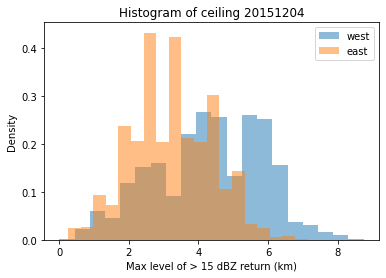

date: 20151210
start time: 1500, end time: 1930
Count west: 340785, count east: 145268


Mean/stdev west: 3.23/1.42

Mean/stdev east: 5.29/1.40


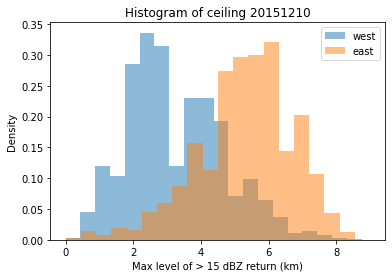

date: 20151213
start time: 1400, end time: 1820
Count west: 397918, count east: 97648


Mean/stdev west: 2.80/1.28

Mean/stdev east: 3.57/0.96


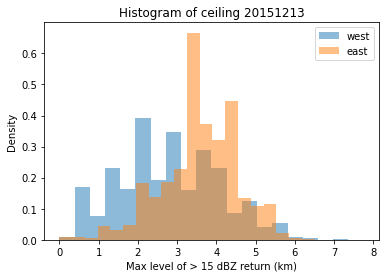

In [20]:
plot_multiple_hist_from_dict(control_dates, save=False)

Count west: 815999, count east: 288171


Mean/stdev west: 3.12/1.44

Mean/stdev east: 4.38/1.53


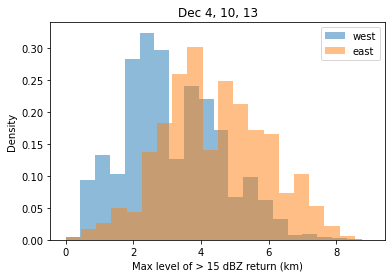

In [29]:
control_west, control_east = combine_and_plot_hist_from_dict(control_dates, title="Dec 4, 10, 13", save=False, 
                                     directory='ceiling_data', return_data=True)

Count west: 37, count east: 34


Mean/stdev west: 3.33/0.68

Mean/stdev east: 3.93/0.95

Student's T-test results:
T-Statistic: -3.068, p-value: 0.003

Mann-Whitney U-test results:
U-Statistic: 367.000, p-value: 0.003


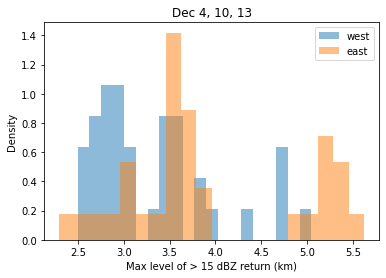

<Figure size 432x288 with 0 Axes>

In [28]:
control_w_means, control_e_means = get_all_means(control_dates, directory='ceiling_data')
plot_means_hist(control_w_means, control_e_means, title='Dec 4, 10, 13')
plt.savefig('hists/hist_control_case_means.png')

In [33]:
control_w_freq, control_e_freq = get_coverage_freq(control_dates, west_out='control', east_out='control', out_arr=True)

ceiling_data/control_west_coverage_freq.npy saved.
ceiling_data/control_east_coverage_freq.npy saved.



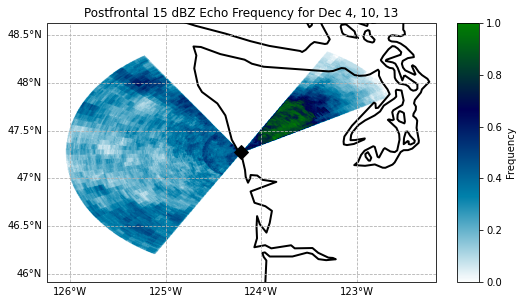

In [34]:
plot_coverage_freq(control_w_freq, control_e_freq, title="Dec 4, 10, 13")
plt.savefig('hists/control_case_frequency.png')

# New Cases

### We find new cases by identifying melting level < 1400m, Moist static stability < -.25, and Integrated Vapor Transport (IVT) < 250 in the NARR Dataset. The NARR dataset contains weather observations for every 3 hours during OLYMPEX. 

## NARR Data

### Load and Clean the data

In [20]:
# Load the data
narr = pd.read_csv("/home/disk/meso-home/adelaf/OLYMPEX/Data/NARR_at_NPOL.csv")

# Convert to DT objects
narr["NARR Time"] = pd.to_datetime(narr['NARR Time'], format='%Y-%m-%d %H:%M:%S')
# format: 2015-11-12 0:00:00'
narr['date'] = narr['NARR Time'].dt.strftime('%Y%m%d')
narr['time'] = narr['NARR Time'].dt.strftime('%H%M')

# Drop all the rows past 1-15-2016 as OLYMPEX had been concluded
drop_index = narr[narr['date'] == '20160116'].index[0] # Find the first entry of 1-16-2016 (beyond OLYMPEX)
narr.drop(narr.iloc[drop_index :, :].index, inplace=True) # Drop all those dates

# Have to convert melting lvls to ints
melt_lvl = narr["Melting Level (m)"].values # get the str levels
int_lvls = [] # to store int lvls
for lvl in range(len(melt_lvl)):
    int_lvl = int(melt_lvl[lvl].replace(',', '')) # remove comma and cast to int
    int_lvls.append(int_lvl)
    
narr['Melting Level (m)'] = int_lvls # Set the new integer levels in the dataframe

# Select some columns for filtering
melt_lvl = narr["Melting Level (m)"]
ivt = narr["IVT"]
Nm = narr["Nm"]
wind = narr['925dir']

# Filter the data to identify postfrontal cases
# Criteria: melt_lvl < 1400m, moist stability < -.25, IVT < 250
postfrontal_loose = narr[(melt_lvl <= 1400) & (ivt <= 250) & (Nm <= -.25)]

# strict critera:
postfrontal_strict = narr[(melt_lvl <= 1200) & (ivt <= 250) & (Nm <= -.25) & ((wind >= 270) | (wind <= 90))]

In [21]:
postfrontal_strict.head()

,NARR Time,IVT,Melting Level (m),925speed (kt),925dir,Nd,Nm,date,time
1,2015-11-12 03:00:00,72,1194,6,290,0.89,-0.31,20151112,0300
28,2015-11-15 12:00:00,95,950,23,328,0.64,-0.58,20151115,1200
29,2015-11-15 15:00:00,125,831,36,316,0.50,-0.68,20151115,1500
30,2015-11-15 18:00:00,99,982,24,317,0.39,-0.85,20151115,1800
31,2015-11-15 21:00:00,76,993,20,310,0.15,-1.10,20151115,2100


### Extract the dates and times

In [22]:
# Some dates don't have data during the postfrontal times, so we need to filter those out too by using the times

In [23]:
def get_postfrontal_cases(postfrontal):
    '''
    postfrontal = dataframe of subsetted NARR data
    Takes in a dataframe of postfrontal NARR cases and finds the start, end times and returns a dictionary with 
    data: [start, end] pairs.
    '''
    unique_dates = postfrontal['date'].unique() # The dates that are postfrontal
    # List of control cases and times
    control_dates = {'20151204': [1300, 1650], '20151210': [1500, 1930], '20151213': [1400, 1820]}
    bad_dates = ['20151125', '20151216']

    pf_cases = {} # For storing date: [start_time, end_time] k, v pairs
    for date in unique_dates:
        # check if in control dates
        if date not in control_dates and date not in bad_dates:
            times = postfrontal[postfrontal['date'] == date]['time'].values # Get the time range
            start = int(times[0])
            end = int(times[-1])
            # If there is only one time available, add 3 hours
            if len(times) == 1: 
                end = start + 300
            # Check that the files exists and that they have times within the postfrontal period
            try:
                west, east = get_olympex_data(date, start, end)
                # check that there is data within the time window
                if len(west) != 0 and len(east) != 0:
                    pf_cases[date] = [start, end]
                else:
                    print(f"No data within time range for {date}")
            except FileNotFoundError:
                print(f"No files found for {date}")
                continue
        # if it is in control dates, do nothing and don't add it to the postfrontal cases
        else:
            continue
    return pf_cases

In [24]:
pf_cases_strict = get_postfrontal_cases(postfrontal_strict)
pf_cases_strict

No data within time range for 20151112
No data within time range for 20151116
No files found for 20151220
No files found for 20151221
No files found for 20151222
No files found for 20151223
No files found for 20151224
No files found for 20151225
No files found for 20151226
No files found for 20151228
No files found for 20151229


{'20151115': [1200, 2100],
 '20151118': [300, 2100],
 '20151124': [900, 1200],
 '20151214': [0, 2100],
 '20151218': [1500, 1800],
 '20160113': [2100, 2400],
 '20160114': [300, 600]}

In [25]:
pf_cases_loose = get_postfrontal_cases(postfrontal_loose)

No data within time range for 20151112
No data within time range for 20151116
No files found for 20151220
No files found for 20151221
No files found for 20151222
No files found for 20151223
No files found for 20151224
No files found for 20151225
No files found for 20151226
No files found for 20151228
No files found for 20151229
No files found for 20160109
No data within time range for 20160115


### We see that, according to our criteria, about 1/5 of the data are postfrontal cases

## Results from using alternate criteria (stricter)

date: 20151115
start time: 1200, end time: 2100
Count west: 142139, count east: 46041


Mean/stdev west: 2.90/1.11

Mean/stdev east: 3.44/0.87


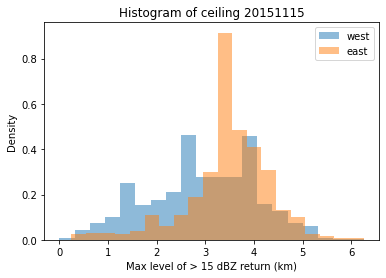

date: 20151118
start time: 300, end time: 2100
Count west: 291738, count east: 78364


Mean/stdev west: 2.21/0.81

Mean/stdev east: 3.03/1.03


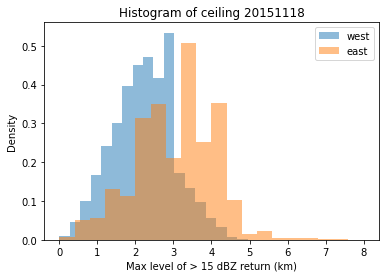

date: 20151124
start time: 900, end time: 1200
Count west: 69676, count east: 7781


Mean/stdev west: 2.41/0.79

Mean/stdev east: 3.00/1.06


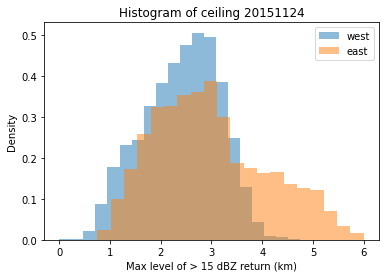

date: 20151214
start time: 0, end time: 2100
Count west: 480820, count east: 69264


Mean/stdev west: 2.66/0.85

Mean/stdev east: 2.23/0.76


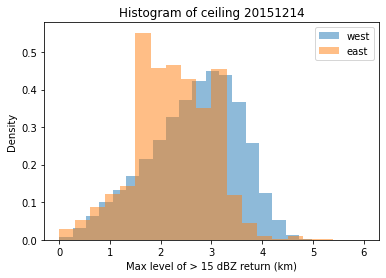

date: 20151218
start time: 1500, end time: 1800
Count west: 55615, count east: 51722


Mean/stdev west: 3.46/1.17

Mean/stdev east: 3.86/1.08


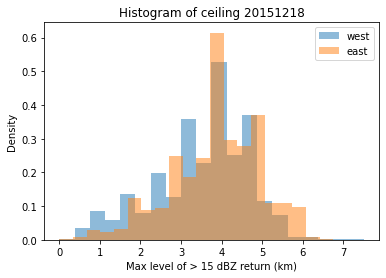

date: 20160113
start time: 2100, end time: 2400
Count west: 4961, count east: 10118


Mean/stdev west: 2.05/0.85

Mean/stdev east: 2.06/0.64


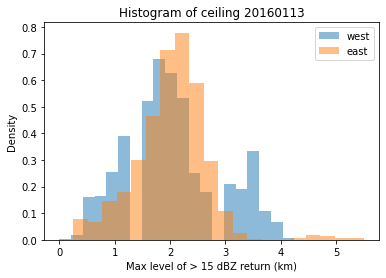

date: 20160114
start time: 300, end time: 600
Count west: 52775, count east: 11313


Mean/stdev west: 3.42/1.16

Mean/stdev east: 2.85/1.15


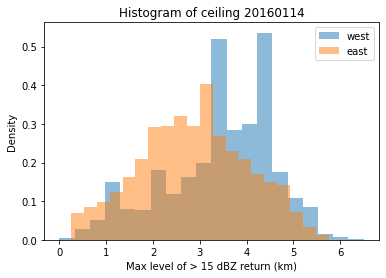

In [40]:
plot_multiple_hist_from_dict(pf_cases_strict, save=False, directory='al')

Count west: 1097724, count east: 274603


Mean/stdev west: 2.63/0.97

Mean/stdev east: 3.01/1.12


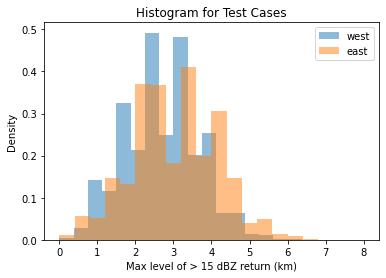

In [26]:
test_west, test_east = combine_and_plot_hist_from_dict(pf_cases_strict, title="Histogram for Test Cases", save=False, 
                                directory='ceiling_data', return_data=True)

Count west: 157, count east: 141


Mean/stdev west: 2.42/0.57

Mean/stdev east: 2.59/0.89

Student's T-test results:
T-Statistic: -1.970, p-value: 0.050

Mann-Whitney U-test results:
U-Statistic: 10410.500, p-value: 0.376


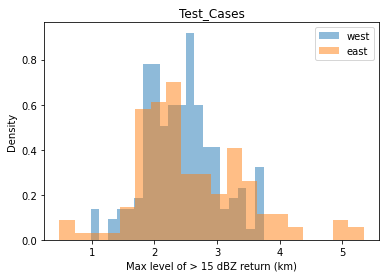

In [27]:
strict_w_means, strict_e_means = get_all_means(pf_cases_strict, directory='alt_ceiling')
plot_means_hist(strict_w_means, strict_e_means, title='Test_Cases')

In [35]:
test_strict_w_freq, test_strict_e_freq = get_coverage_freq(pf_cases_strict, west_out='test', east_out='test', out_arr=True, directory='alt_ceiling')

alt_ceiling/test_west_coverage_freq.npy saved.
alt_ceiling/test_east_coverage_freq.npy saved.



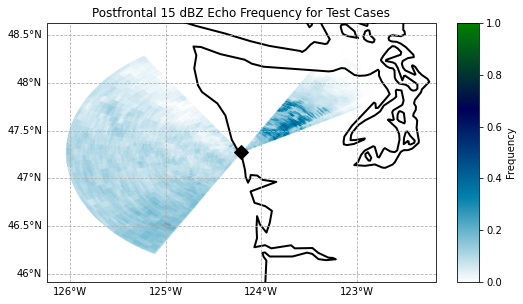

In [36]:
plot_coverage_freq(test_strict_w_freq, test_strict_e_freq, title="Test Cases")

# Let's try some stats

## Final plots for poster

In [ ]:
# raw histogram of all values
# t-test on the raw data
# 

In [30]:
# All raw data
all_west_raw = np.append(control_west, test_west)
all_east_raw = np.append(control_east, test_east)

In [31]:
all_dates = {}
all_dates.update(control_dates)
all_dates.update(pf_cases_strict)
all_dates

{'20151204': [1300, 1650],
 '20151210': [1500, 1930],
 '20151213': [1400, 1820],
 '20151115': [1200, 2100],
 '20151118': [300, 2100],
 '20151124': [900, 1200],
 '20151214': [0, 2100],
 '20151218': [1500, 1800],
 '20160113': [2100, 2400],
 '20160114': [300, 600]}

Count west: 1913723, count east: 562774


Mean/stdev west: 2.84/1.22

Mean/stdev east: 3.71/1.51


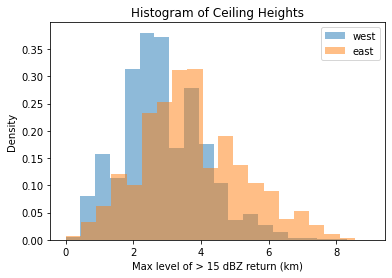

In [44]:
combine_and_plot_hist_from_dict(all_dates, title='Histogram of Ceiling Heights', directory='ceiling_data', save=False, return_data=False)

In [30]:
1913723 + 562774 -2

2476495

In [46]:
# p-value of zero is good, but sample size is large is may be skewed, so we do the means as well
stats.ttest_ind(all_east_raw, all_west_raw)

Ttest_indResult(statistic=446.45333288513564, pvalue=0.0)

### Histograms of the distribution of the means

Count west: 37, count east: 34


Mean/stdev west: 3.33/0.68

Mean/stdev east: 3.93/0.95

Student's T-test results:
T-Statistic: -3.068, p-value: 0.003

Mann-Whitney U-test results:
U-Statistic: 367.000, p-value: 0.003


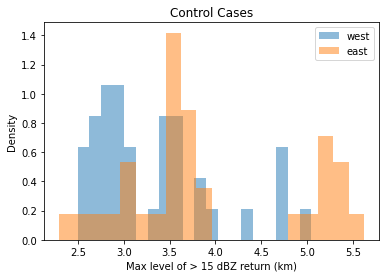

In [48]:
control_w_means, control_e_means = get_all_means(control_dates, directory='ceiling_data')
plot_means_hist(control_w_means, control_e_means, title='Control Cases')

Count west: 157, count east: 141


Mean/stdev west: 2.42/0.57

Mean/stdev east: 2.59/0.89

Student's T-test results:
T-Statistic: -1.970, p-value: 0.050

Mann-Whitney U-test results:
U-Statistic: 10410.500, p-value: 0.376


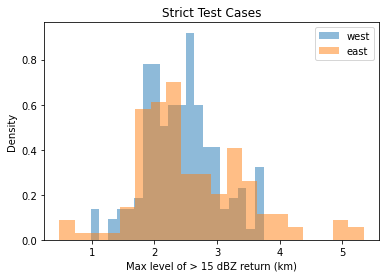

In [49]:
strict_w_means, strict_e_means = get_all_means(pf_cases_strict, directory='alt_ceiling')
plot_means_hist(strict_w_means, strict_e_means, title='Strict Test Cases')

## Combine all the means and plot hist

In [50]:
all_west_means = np.concatenate((control_w_means, strict_w_means))
all_east_means = np.concatenate((control_e_means, strict_e_means))

In [31]:
194 + 175 - 2

367

Count west: 194, count east: 175


Mean/stdev west: 2.59/0.69

Mean/stdev east: 2.85/1.04

Student's T-test results:
T-Statistic: -2.805, p-value: 0.005

Mann-Whitney U-test results:
U-Statistic: 15159.500, p-value: 0.076


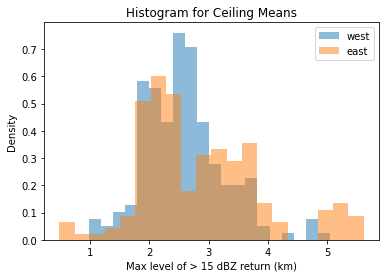

In [51]:
plot_means_hist(all_west_means, all_east_means, title='Histogram for Ceiling Means')

In [52]:
all_w_freq, all_e_freq = get_coverage_freq(all_dates, west_out='all_west', east_out='all_east', out_arr=True, directory='ceiling_data')

ceiling_data/all_west_west_coverage_freq.npy saved.
ceiling_data/all_east_east_coverage_freq.npy saved.



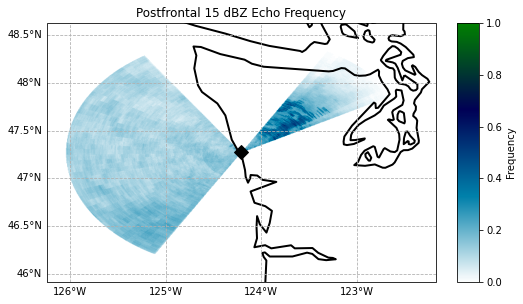

In [54]:
plot_coverage_freq(all_w_freq, all_e_freq, title="Test Cases")

### Use Shapiro-Wilk test for normality

In [37]:
stats.shapiro(all_west), stats.shapiro(all_east)

(ShapiroResult(statistic=0.9702857136726379, pvalue=0.0003897626302205026),
 ShapiroResult(statistic=0.9454174041748047, pvalue=2.9805776193825295e-06))

### We see the data are not normally distributed

In [38]:
stats.ttest_ind(all_east, all_west, alternative='greater')

Ttest_indResult(statistic=2.805122963888393, pvalue=0.002648761598237922)

In [39]:
stats.mannwhitneyu(all_east, all_west, alternative='greater')

MannwhitneyuResult(statistic=18790.5, pvalue=0.03803396992124484)

Count west: 194, count east: 175


Mean/stdev west: 2.59/0.69

Mean/stdev east: 2.85/1.04

Student's T-test results:
T-Statistic: -2.805, p-value: 0.005

Mann-Whitney U-test results:
U-Statistic: 15159.500, p-value: 0.076


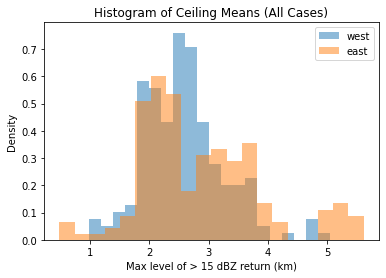

In [40]:
plot_means_hist(all_west, all_east, title='All Cases')

## T-tests

In [88]:
stats.ttest_ind(all_west, all_east)

Ttest_indResult(statistic=-2.805122963888393, pvalue=0.005297523196475844)

In [98]:
x = stats.ttest_ind(control_w_means, control_e_means)
x

Ttest_indResult(statistic=-3.067660516245608, pvalue=0.003081172969678392)

In [69]:
sample_strict_west.min()

0.0

In [41]:
stats.shapiro(sample_strict_west)

ShapiroResult(statistic=0.978477954864502, pvalue=7.164762149307775e-27)

In [42]:
stats.shapiro(sample_strict_east)

ShapiroResult(statistic=0.9850336313247681, pvalue=1.3003663941019853e-22)

In [47]:
stats.ttest_ind(all_loose_west, all_loose_east)

Ttest_indResult(statistic=-132.85920412552628, pvalue=0.0)

weird issues with:<br>
20151125<br>
20151216<br>



Double check with OLYMPEX archives<br>
11-15-2015 1200-1500 UTC<br>
11-18-2015 0-1200<br>
11-24-2015 0400-1200<br>
12-18-2015 1000-1800?<br>
12-19-2015 00-2000<br>
12-20 (no summary available)<br>
12-21-2015 0600-1000<br>
12-22-2015 00-2100<br>


# Radar plotting functions. Used previously in exploratory analysis

In [67]:
def plot_rad_from_array(dat, elev_ind):
    
    radar_coords = [-124.211, 47.277] # lon, lat
    
    # Build the map projection
    fig = plt.figure()
    proj = ccrs.PlateCarree()
    ax = fig.ax = plt.axes([0, 0.05, 0.9, 0.9 ], projection=proj)
    extent = [lon.min(), lon.max(), lat.min(), lat.max()] # map boundaries
    ax.set_extent(extent)
    gl = ax.gridlines(draw_labels=True, crs=proj, linestyle='--') # Gridlines
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines(resolution='50m', linewidth=2) # Coastlines
    # Do the Plotting
    im = ax.imshow(DBZ_west[0,elev_ind,::-1,:], extent=extent, transform=proj, cmap=cmap)
    ax.imshow(DBZ_east[0,elev_ind,::-1,:], extent=extent, transform=proj, cmap=cmap)
    ax.plot(radar_coords[0], radar_coords[1], marker='D', color='red', markersize=10)
    plt.title(timestamp[0] + ' T' + timestamp[1][:8] + ' Elevation=' + str(elevation) + ' (km)')
    cax = plt.axes([0.95, 0.05, 0.05,0.9 ])
    cbar = fig.colorbar(mappable=im, cax=cax, label='DBZ')
    im.set_clim(5, 60)
    # Maybe add a save feature
    plt.draw()

In [68]:
def plot_west_east_scan(west_scan, east_scan, elev_ind):
    '''
    Takes in Olympex hires data and plots the east and west sector scans.
    
    west_scan: file path for west scan data
    east_scan: file path for east scan data
    elev_ind: Index for the desired elevation, indexes (dat['z0'])
    radar_coords: Coordinates to mark the radar location [longitude, latitude], use negative for W or S 
    '''
    from metpy.plots import ctables
    from matplotlib.colors import Normalize
    cmap = ctables.registry.get_colortable('NWSReflectivity')
    # cmap = 'gist_ncar'
    
    radar_coords = [-124.211, 47.277] # lon, lat
    
    # Load the data
    dat_west = xr.open_dataset(west_scan) 
    dat_east = xr.open_dataset(east_scan)
        
    # Grab data
    timestamp = np.datetime_as_string(dat_west['start_time'][0].values).split('T') # Get date and time
    lon = dat_west['lon0'][:] # Longitudes
    lat = dat_west['lat0'][:] # Latitudes
    x = dat_west['x0'][:]
    y = dat_west['y0'][:]
    DBZ_west = dat_west['DBZ'] # DBZ radar return
    DBZ_east = dat_east['DBZ']
    elevation = DBZ_west['z0'][elev_ind].values
    
    # Build the map projection
    fig = plt.figure()
    proj = ccrs.PlateCarree()
    ax = fig.ax = plt.axes([0, 0.05, 0.9, 0.9 ], projection=proj)
    extent = [lon.min(), lon.max(), lat.min(), lat.max()] # map boundaries
    ax.set_extent(extent)
    gl = ax.gridlines(draw_labels=True, crs=proj, linestyle='--') # Gridlines
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines(resolution='50m', linewidth=2) # Coastlines
    # Do the Plotting
    im = ax.imshow(DBZ_west[0,elev_ind,::-1,:], extent=extent, transform=proj, cmap=cmap)
    ax.imshow(DBZ_east[0,elev_ind,::-1,:], extent=extent, transform=proj, cmap=cmap)
    ax.plot(radar_coords[0], radar_coords[1], marker='D', color='red', markersize=10)
    plt.title(timestamp[0] + ' T' + timestamp[1][:8] + ' Elevation=' + str(elevation) + ' (km)')
    cax = plt.axes([0.95, 0.05, 0.05,0.9 ])
    cbar = fig.colorbar(mappable=im, cax=cax, label='DBZ')
    im.set_clim(5, 60)
    # Maybe add a save feature
    plt.draw()